<center><h1>Escenarios experimentales Internetworking</h1></center>

Presentado por: Holger Fernando Catucuamba Nepas <br>
Fecha: 23/02/2023

##  Importación de librerias necesarias

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Cargar el Dataset

In [43]:
datapath = 'https://raw.githubusercontent.com/hfcatucuamba/proyectoInternetworking/main/Escenario1.csv'
dataframe = pd.read_csv(datapath,low_memory=False, sep=';')

In [44]:
dataframe.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0,45.977.011.494.253,435,0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0,77.220.077.220.077,259,0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0,22.446.689.113.356,891,0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0,18.621.973.929.237,1074,0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0,63.492.063.492.064,315,0,...,0,0,0,0,0,0,0,0,0,nonTOR


## Normalizar los datos

In [45]:
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df

In [46]:
print (dataframe.shape)
dataframe = dataframe.reindex(np.random.permutation(dataframe.index)).copy()
print(dataframe.describe())
print (list(dataframe))

(7000, 29)
        Source Port   Destination Port   Protocol   Flow Duration  \
count   7000.000000        7000.000000     7000.0    7.000000e+03   
mean   42153.076571        7647.390714        6.0    4.002204e+06   
std    17081.978193       17168.713987        0.0    4.450485e+06   
min       80.000000          21.000000        6.0    1.700000e+01   
25%    38894.000000         443.000000        6.0    2.013598e+05   
50%    45337.000000         443.000000        6.0    4.409195e+05   
75%    54698.000000         443.000000        6.0    9.829612e+06   
max    61156.000000       65514.000000        6.0    1.000000e+07   

        Flow IAT Max   Flow IAT Min   Fwd IAT Max   Fwd IAT Min   Bwd IAT Max  \
count   7.000000e+03   7.000000e+03  7.000000e+03  7.000000e+03  7.000000e+03   
mean    1.148187e+06   1.023332e+05  1.079414e+06  1.035305e+05  8.884348e+05   
std     2.113319e+06   4.321051e+05  2.135818e+06  6.952060e+05  1.933856e+06   
min     1.700000e+01  -4.340000e+02  0.0000

In [47]:
keys = dataframe.keys()
data_to_process = dataframe[keys[4:len(keys) - 1]].copy()
x_normalised = dfNormalize(data_to_process)
print(x_normalised.describe())

        Protocol   Flow Duration   Flow Bytes/s   Flow Packets/s  \
count     7000.0     7000.000000    7000.000000      7000.000000   
mean         0.0        0.400219       0.000143         0.000167   
std          0.0        0.445049       0.011952         0.012051   
min          0.0        0.000000       0.000000         0.000000   
25%          0.0        0.020134       0.000000         0.000000   
50%          0.0        0.044090       0.000000         0.000000   
75%          0.0        0.982961       0.000000         0.000000   
max          0.0        1.000000       1.000000         1.000000   

        Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  \
count     7000.000000         7000.0    7000.000000    7000.000000   
mean         0.017407            0.0       0.114853       0.010376   
std          0.055836            0.0       0.211398       0.043627   
min          0.000000            0.0       0.000000       0.000000   
25%          0.000000            0.0 


## Obtener los datos para entrenar y de prueba

In [48]:
change_labels = lambda x: 1 if x == 'nonTOR' else 0

In [49]:
y_normalised = dataframe['label'].apply(change_labels)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x_normalised,
                                            y_normalised, test_size=0.3, random_state=42)

## Crear Modelo 

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

#1st Convolutional Layer
model.add(Conv1D(filters=32, input_shape=(X_train.shape[1], 1), kernel_size=3, strides=1, padding='valid'))
model.add(Activation('relu'))

#Max Pooling
model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

#2nd Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='valid'))
model.add(Activation('relu'))

#Max Pooling
model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

#3rd Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='valid'))
model.add(Activation('relu'))

#4th Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='valid'))
model.add(Activation('relu'))

#Max Pooling
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))

#Fully Connected layer
model.add(Flatten())

#1st Fully Connected Layer
model.add(Dense(512))
model.add(Activation('relu'))

#Add Dropout to prevent overfitting
model.add(Dropout(0.3))

#Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(optimizer="adam",
              loss="binary_crossentropy", 
              metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 22, 32)            128       
                                                                 
 activation_12 (Activation)  (None, 22, 32)            0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 32)            3104      
                                                                 
 activation_13 (Activation)  (None, 18, 32)            0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 16, 32)           0         
 1D)                                                  

In [52]:
batch_size = 32
steps_per_epoch = (X_train.shape[0]//batch_size)
validation_steps = (x_normalised.shape[0]//batch_size)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=200)

In [53]:
%%time

# Entrenar el modelo
model.fit(X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 35,
    validation_data=(X_test, y_test),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

Epoch 1/35
153/153 [==============================] - 4s 14ms/step - loss: 0.1977 - accuracy: 0.9461 - val_loss: 0.0920 - val_accuracy: 0.9733
Epoch 2/35
153/153 [==============================] - 3s 17ms/step - loss: 0.0770 - accuracy: 0.9790
Epoch 3/35
153/153 [==============================] - 3s 18ms/step - loss: 0.0560 - accuracy: 0.9842
Epoch 4/35
153/153 [==============================] - 2s 12ms/step - loss: 0.0538 - accuracy: 0.9834
Epoch 5/35
153/153 [==============================] - 2s 14ms/step - loss: 0.0411 - accuracy: 0.9862
Epoch 6/35
153/153 [==============================] - 2s 12ms/step - loss: 0.0477 - accuracy: 0.9854
Epoch 7/35
153/153 [==============================] - 3s 17ms/step - loss: 0.0397 - accuracy: 0.9883
Epoch 8/35
153/153 [==============================] - 2s 14ms/step - loss: 0.0347 - accuracy: 0.9885
Epoch 9/35
153/153 [==============================] - 2s 15ms/step - loss: 0.0428 - accuracy: 0.9856
Epoch 10/35
153/153 [============================

In [54]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

66/66 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.9914
test_loss: 3.24
test_accuracy: 99.14


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

# Convertir las probabilidades en etiquetas binarias (0 o 1) usando un umbral de 0.5
y_pred_binary = (y_pred > 0.5).astype(int)
 
# calcular métricas de evaluación
acc = accuracy_score(y_test, y_pred_binary)*100
f1 = f1_score(y_test, y_pred_binary, average='weighted')*100
prec = precision_score(y_test, y_pred_binary, average='weighted')*100
rec = recall_score(y_test, y_pred_binary, average='weighted')*100

print('Accuracy: %.2f' % acc)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % prec)
print('Recall: %.2f' % rec)

66/66 [==============================] - 1s 3ms/step
Accuracy: 99.14
F1 score: 99.14
Precision: 99.15
Recall: 99.14


## Gráfico Roc Curve

66/66 [==============================] - 0s 3ms/step


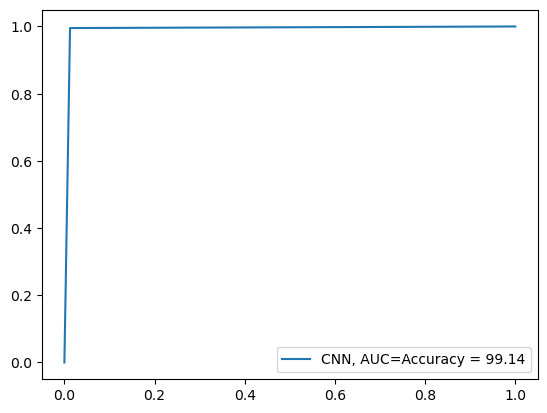

In [56]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
CNN = "Accuracy = {:.2f}".format(accuracy*100)
plt.plot(fpr, tpr, label="CNN, AUC=" + str(CNN))
plt.legend()